In [15]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [16]:
file_path = "20230914_processed_table.csv"
wavelength_string = "750-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
# print("Interleaved Values")
# print("Length: ", len(interleaved_values))
# print(interleaved_values)
# print("Interleaved Stds")
# print("Length: ", len(interleaved_stds))
# print(interleaved_stds[0 : 10])
# print("Configuration List")
# print("Length: ", len(configuration_list))
# print(configuration_list)
# print(interleaved_stds[0])

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [17]:
import numpy as np
past_fit = np.load("scipy_minimize_20230914_720nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

Past Fit:  [ 4.99984042  0.44887049  1.08704114  0.40140005 -4.99999346 -0.21697373
  0.09999933 21.36101844  0.51787551  0.43110147  1.18869275]


In [18]:
# Loading in previous fit from vampires_calibration
filename = "750-50_restrictive_HWP_FLC_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
with open(filename, "r") as f:
    past_fit = json.load(f)

print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
# em_gain = past_fit["wollaston"]["transmission_ratio"]
em_gain = 0.9937459726763582 # from the dark-subtracted images

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.64  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 0, 'epsilon': 0, 'theta': 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {'phi': 2 * np.pi * delta_opts, 'epsilon': epsilon_opts, 'theta': rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

print(system_dict)

{'wollaston': {'transmission_ratio': 1.0828225566195386}, 'dichroic': {'phi': 0.7862801778133213, 'epsilon': 0.05531068820953189, 'theta': -12.925342551659114}, 'flc': {'phi': 3.5680565693727475, 'delta_theta': 4.7589573115734325}, 'optics': {'phi': 1.3787258519831789, 'epsilon': 2.948814172692918e-15, 'theta': -2.5141103963573332}, 'image_rotator': {'phi': 3.0762894413855033}, 'hwp': {'phi': 2.9989596271627486, 'delta_theta': 2.0263106422009267}, 'lp': {'theta': 1.2434620117388722}}
{'components': {'wollaston': {'type': 'wollaston_prism_function', 'properties': {'beam': 'o', 'transmission_ratio': 0.9937459726763582}}, 'dichroic': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 0, 'epsilon': 0, 'theta': 0}}, 'flc': {'type': 'general_retarder_function', 'properties': {'phi': 22.418760611868446, 'theta': 0, 'delta_theta': 4.7589573115734325}}, 'optics': {'type': 'diattenuator_retarder_function', 'properties': {'phi': 8.662790015809367, 'epsilon': 2.948814172692918e-15, '

In [19]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.46286476 0.46242881 0.02008434 0.        ]
 [0.46286476 0.46242881 0.02008434 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 1654.2657583677392


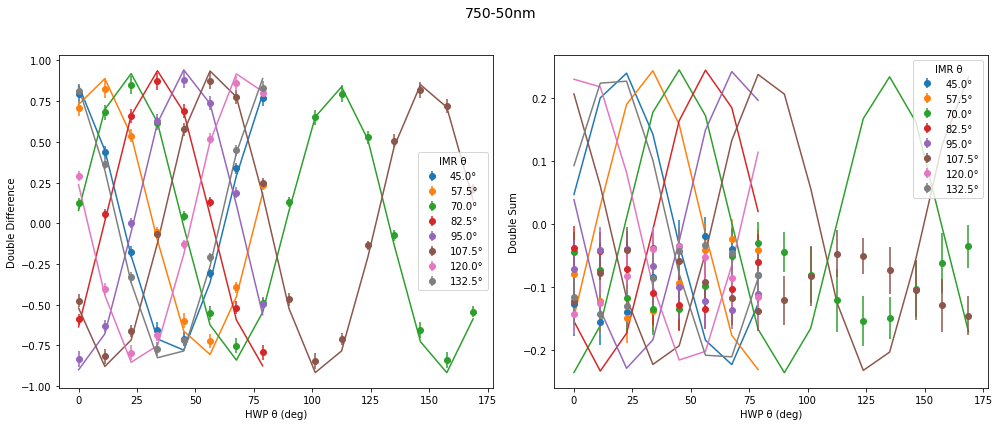

In [20]:
# Fittin for all parameters
p0 = {
    "dichroic": {"phi": 0, 
                 "epsilon": 0, 
                 "theta": 0},
    "flc": {"phi": delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi":delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'dichroic': {'phi': 0, 'epsilon': 0, 'theta': 0}, 'flc': {'phi': 3.5680565693727475, 'delta_theta': 4.7589573115734325}, 'optics': {'phi': 1.3787258519831789, 'epsilon': 2.948814172692918e-15, 'theta': -2.5141103963573332}, 'image_rotator': {'phi': 3.0762894413855033}, 'hwp': {'phi': 2.9989596271627486, 'delta_theta': 2.0263106422009267}, 'lp': {'theta': 1.2434620117388722}}


Iteration #: 1
logl_value: 60.891827123899404
Best Fit Parameters: [-4.13643018e-02  8.70510199e-02 -5.43799310e-02  3.05026364e+00
  3.79015650e+00  1.20798782e+00  4.04964303e-15 -8.83687574e+00
  3.07129421e+00  3.00407918e+00  3.57259183e+00 -4.86068835e+00]


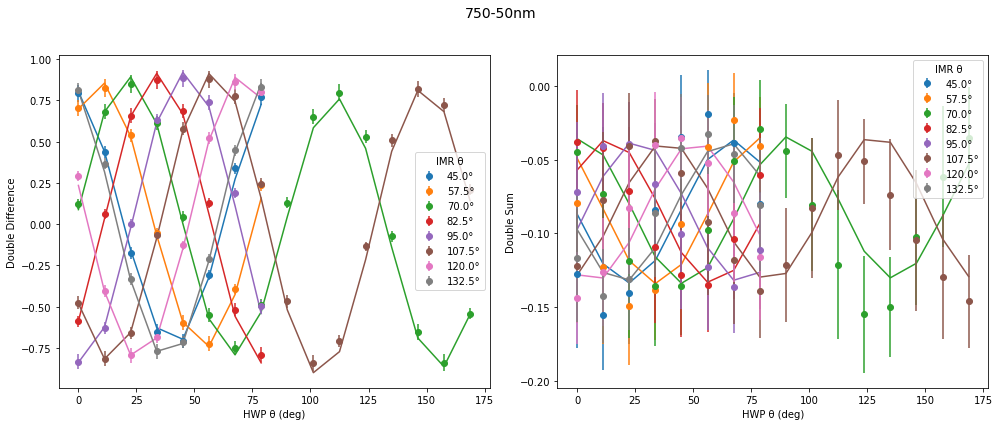

After p0: {'dichroic': {'phi': -0.041364301759752725, 'epsilon': 0.08705101991363262, 'theta': -0.054379930998494586}, 'flc': {'phi': 3.0502636358037627, 'delta_theta': 3.790156497406535}, 'optics': {'phi': 1.2079878180491672, 'epsilon': 4.049643033450901e-15, 'theta': -8.836875742423953}, 'image_rotator': {'phi': 3.071294211059932}, 'hwp': {'phi': 3.00407918374092, 'delta_theta': 3.57259182560104}, 'lp': {'theta': -4.860688351933003}}
Before p0: {'dichroic': {'phi': -0.041364301759752725, 'epsilon': 0.08705101991363262, 'theta': -0.054379930998494586}, 'flc': {'phi': 3.0502636358037627, 'delta_theta': 3.790156497406535}, 'optics': {'phi': 1.2079878180491672, 'epsilon': 4.049643033450901e-15, 'theta': -8.836875742423953}, 'image_rotator': {'phi': 3.071294211059932}, 'hwp': {'phi': 3.00407918374092, 'delta_theta': 3.57259182560104}, 'lp': {'theta': -4.860688351933003}}
Iteration #: 2
logl_value: 55.5166352020385
Best Fit Parameters: [-3.08274619e-02  8.92497585e-02  2.54965633e+00  3.05

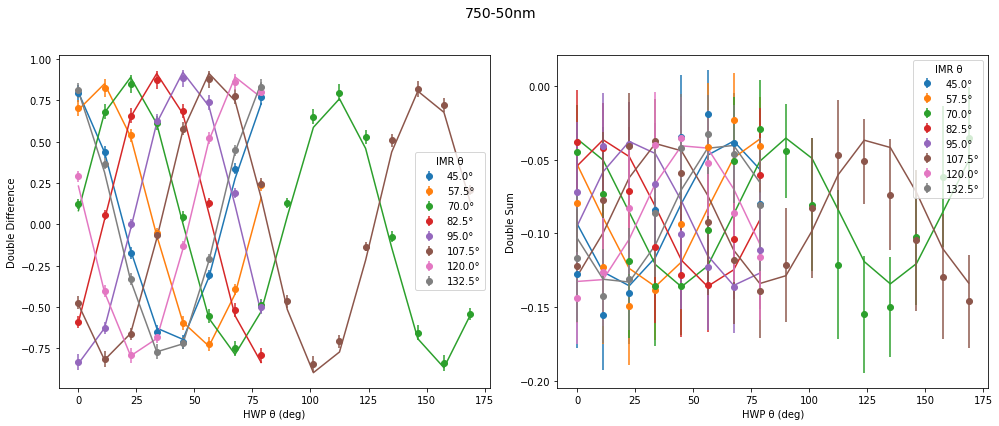

After p0: {'dichroic': {'phi': -0.030827461932770236, 'epsilon': 0.0892497585166453, 'theta': 2.54965632502271}, 'flc': {'phi': 3.05860558577501, 'delta_theta': 4.997845119373416}, 'optics': {'phi': 1.3549632349914145, 'epsilon': 1.700599989500144e-13, 'theta': -5.879441169358497}, 'image_rotator': {'phi': 3.0707439387794304}, 'hwp': {'phi': 3.003376306356021, 'delta_theta': 4.999784328549909}, 'lp': {'theta': -1.5945685053923477}}
Before p0: {'dichroic': {'phi': -0.030827461932770236, 'epsilon': 0.0892497585166453, 'theta': 2.54965632502271}, 'flc': {'phi': 3.05860558577501, 'delta_theta': 4.997845119373416}, 'optics': {'phi': 1.3549632349914145, 'epsilon': 1.700599989500144e-13, 'theta': -5.879441169358497}, 'image_rotator': {'phi': 3.0707439387794304}, 'hwp': {'phi': 3.003376306356021, 'delta_theta': 4.999784328549909}, 'lp': {'theta': -1.5945685053923477}}
Iteration #: 3
logl_value: 41.23285064674562
Best Fit Parameters: [-3.43926892e-01  1.81701180e-01  2.93078660e+01  3.57112901e

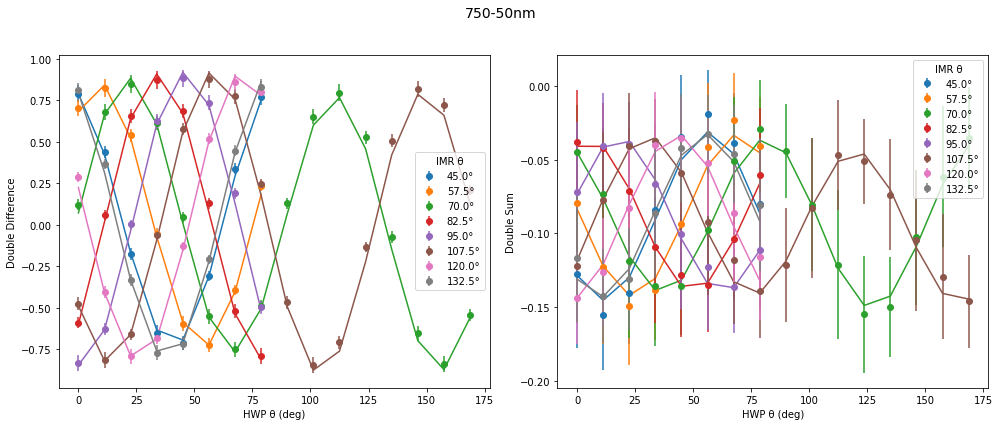

After p0: {'dichroic': {'phi': -0.3439268919770915, 'epsilon': 0.18170118003236668, 'theta': 29.307866038828436}, 'flc': {'phi': 3.571129007113102, 'delta_theta': 4.875708795020106}, 'optics': {'phi': 1.3991157492403268, 'epsilon': 2.5905654880291954e-13, 'theta': -6.305811867662225}, 'image_rotator': {'phi': 3.07802430295283}, 'hwp': {'phi': 2.9924375545871893, 'delta_theta': 4.8448508728523265}, 'lp': {'theta': 3.937817256988726}}
Before p0: {'dichroic': {'phi': -0.3439268919770915, 'epsilon': 0.18170118003236668, 'theta': 29.307866038828436}, 'flc': {'phi': 3.571129007113102, 'delta_theta': 4.875708795020106}, 'optics': {'phi': 1.3991157492403268, 'epsilon': 2.5905654880291954e-13, 'theta': -6.305811867662225}, 'image_rotator': {'phi': 3.07802430295283}, 'hwp': {'phi': 2.9924375545871893, 'delta_theta': 4.8448508728523265}, 'lp': {'theta': 3.937817256988726}}
Iteration #: 4
logl_value: 39.9466011709759
Best Fit Parameters: [-3.45336045e-01  1.93307028e-01  3.06040298e+01  3.67037975

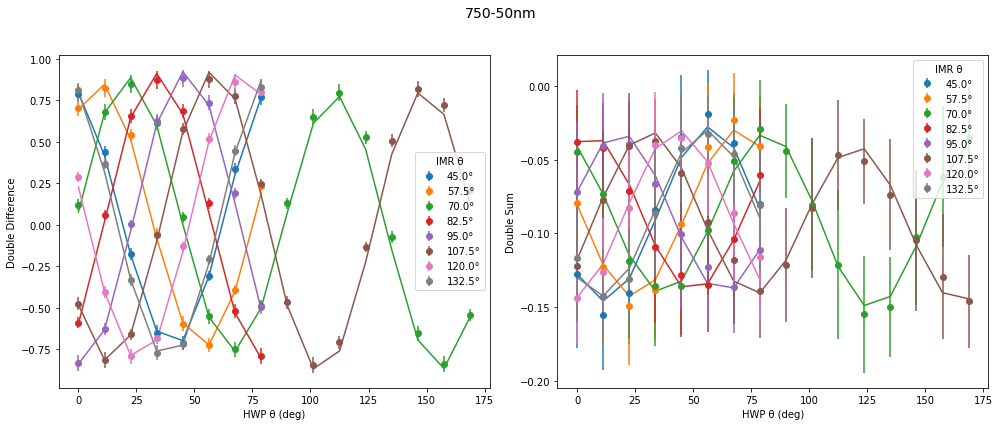

After p0: {'dichroic': {'phi': -0.3453360454791009, 'epsilon': 0.1933070281774362, 'theta': 30.604029842748442}, 'flc': {'phi': 3.670379748897357, 'delta_theta': 4.914826043126349}, 'optics': {'phi': 0.8138252648881099, 'epsilon': 8.167698224317516e-12, 'theta': -20.300100105968465}, 'image_rotator': {'phi': 3.0734146246142675}, 'hwp': {'phi': 2.9955135380671076, 'delta_theta': -1.4104101801617646}, 'lp': {'theta': -2.1829200781481592}}
Before p0: {'dichroic': {'phi': -0.3453360454791009, 'epsilon': 0.1933070281774362, 'theta': 30.604029842748442}, 'flc': {'phi': 3.670379748897357, 'delta_theta': 4.914826043126349}, 'optics': {'phi': 0.8138252648881099, 'epsilon': 8.167698224317516e-12, 'theta': -20.300100105968465}, 'image_rotator': {'phi': 3.0734146246142675}, 'hwp': {'phi': 2.9955135380671076, 'delta_theta': -1.4104101801617646}, 'lp': {'theta': -2.1829200781481592}}
Iteration #: 5
logl_value: 38.29328548539612
Best Fit Parameters: [-1.59133206e-01  2.97401979e-01  3.58960432e+01  3

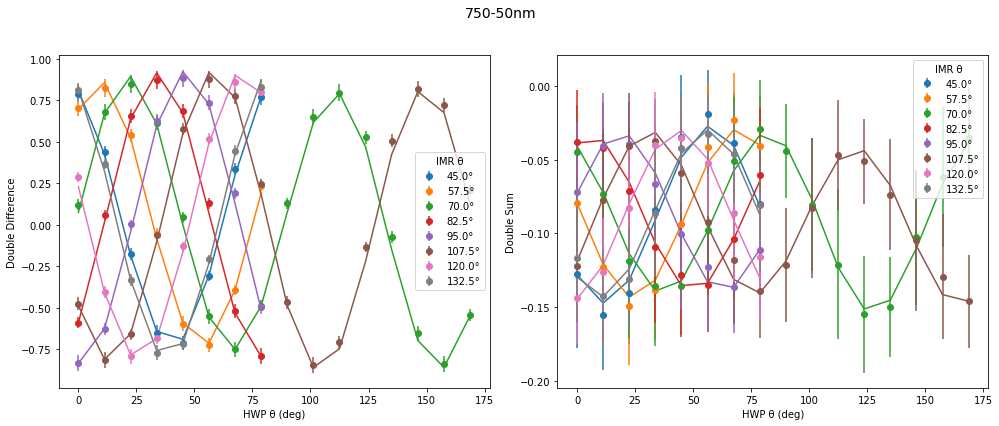

After p0: {'dichroic': {'phi': -0.159133206282354, 'epsilon': 0.29740197906812316, 'theta': 35.89604319358037}, 'flc': {'phi': 3.5251028223375975, 'delta_theta': 3.737022189619667}, 'optics': {'phi': 0.8310075148482585, 'epsilon': 4.016396721100822e-11, 'theta': -57.95361017915991}, 'image_rotator': {'phi': 3.0686400293850804}, 'hwp': {'phi': 2.98188612725511, 'delta_theta': -1.718261281613799}, 'lp': {'theta': -1.3498295392882138}}
Before p0: {'dichroic': {'phi': -0.159133206282354, 'epsilon': 0.29740197906812316, 'theta': 35.89604319358037}, 'flc': {'phi': 3.5251028223375975, 'delta_theta': 3.737022189619667}, 'optics': {'phi': 0.8310075148482585, 'epsilon': 4.016396721100822e-11, 'theta': -57.95361017915991}, 'image_rotator': {'phi': 3.0686400293850804}, 'hwp': {'phi': 2.98188612725511, 'delta_theta': -1.718261281613799}, 'lp': {'theta': -1.3498295392882138}}
Iteration #: 6
logl_value: 38.216905901670785
Best Fit Parameters: [-1.50605291e-01  2.94726075e-01  3.58081297e+01  3.523167

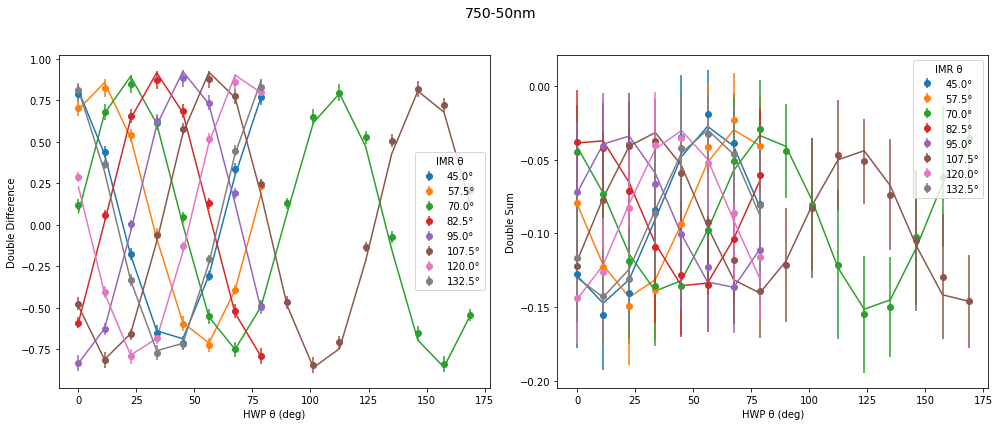

After p0: {'dichroic': {'phi': -0.15060529133346875, 'epsilon': 0.2947260746883915, 'theta': 35.808129724830195}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}


In [21]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    ((delta_derot - delta_derot * 0.1), (delta_derot + delta_derot * 0.1)),  # delta_derot
    # (-1, 1),  # offset_derot
    ((delta_HWP - delta_HWP * 0.1), (delta_HWP + delta_HWP * 0.1)),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]
# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_restrictive_HWP_FLC_no_IMR_offset_fixed_EM_gain_with_dichroic_best_fit.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

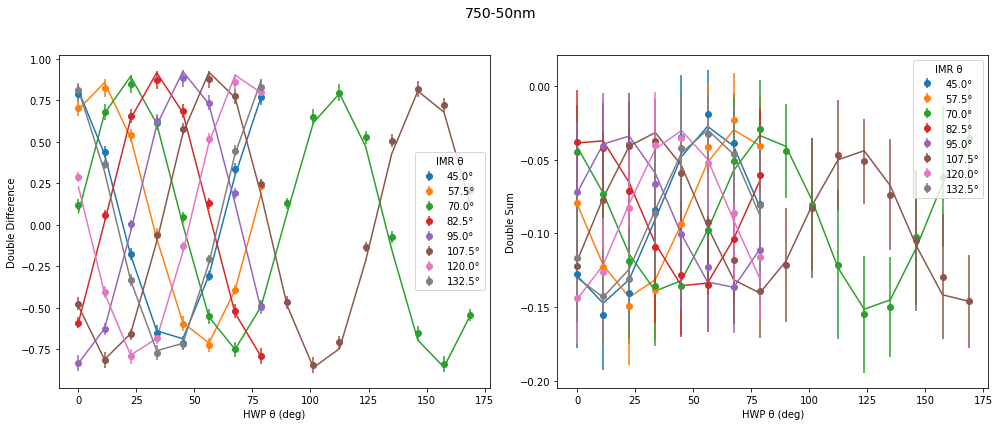

In [22]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)